In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array

import sys
sys.path.append('../')
import snowFun

In [2]:
# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_dems = os.path.join(folder_AGVA, "DEMs", "time_varying_DEMs", "10m")
folder_class = os.path.join(folder_AGVA, 'classified images', 'S2_Classified_Cloudmasked_Merged')
folder_cloud = os.path.join(folder_AGVA, 'classified images', 'S2_Cloud_Merged')
folder_meta = os.path.join(folder_AGVA, "classified images", "meta csv", "S2")
folder_mask = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Masks')

# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "rgi_2km_o3regions", "rgi_2km_o3regions.shp")
rgi_gdf = gpd.read_file(path_rgi, drop='geometry')

In [3]:
### choose if you want to do only the 45 validation glaciers
validation_only = 0

# open list of validation glaciers
all_validation_df = pd.read_csv(os.path.join(folder_AGVA, 'Validation', 'Validation Glaciers.csv'))

# select which rgis to analyze
if validation_only:
    folder_save = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Validation')
else:
    folder_save = os.path.join(folder_AGVA, 'Derived products', 'S2')

# get list of rgis to analyze
rgis_to_analyze = list(set( [ i[3:17] for i in os.listdir(os.path.join(folder_save, "Average AAs")) if i[-3:]=='tif' ] ))

# get list of glacier area for each rgi
areas = [rgi_gdf[rgi_gdf['RGIId']==i]['Area'].values for i in rgis_to_analyze]

# make df
rgis_to_analyze_df = pd.DataFrame({"RGIId":rgis_to_analyze, 'Area':areas})

# sort however you want
rgis_to_analyze_df = rgis_to_analyze_df.sort_values('Area')

# grab rgi names
rgis_to_analyze = rgis_to_analyze_df['RGIId'].values

print(len(rgis_to_analyze_df))
# print(rgis_to_analyze[:10])
# print(rgis_to_analyze_df[:10])

3002


### First step: go through to get the snow cover fraction of elevation bands in the average AA product for each glacier

In [14]:
for i in range(len(rgis_to_analyze)):

    # subset rgi to single outline, by choosing rgiid or rgi name
    rgiid = rgis_to_analyze[i]
    
#     if rgiid!="RGI60-01.09162": continue

    # check if we've already run this glacier. if so, skip
    temp_path = os.path.join(folder_save, 'Average AAs', 'Band SCFs', f"{rgiid}.csv")
#     if os.path.exists(temp_path):
#         continue

    # quickly grab glacier area
    ga = rgi_gdf[rgi_gdf['RGIId']==rgiid]['Area'].values[0]
#     if ga<3300: continue
    # print progress
    print(f"Starting {i+1} of {len(rgis_to_analyze)}: {rgiid}  {ga} km2")
    
    # grab just this rgi geometry and info
    rgi_single = rgi_gdf[rgi_gdf['RGIId']==rgiid].to_crs("EPSG:3338")
    single_geometry = rgi_single.geometry
    
    # define the coarsen scale
    if ga>1000:
        scale=1
    elif ga>500:
        scale=1
    else:
        scale=1
        
    # open glacier mask
    glacier_mask = xr.open_dataset(os.path.join(folder_mask, f"S2_{rgiid}_mask.nc"), chunks='auto').glacier
    
    if ga>500:
        glacier_mask = glacier_mask.coarsen({"x":scale, "y":scale}, boundary="trim").median(skipna=True).astype('uint8')  
    
    # open the average AA map
    path_open = os.path.join(folder_save, 'Average AAs', f"S2_{rgiid}_2018_2022_average_AA_final.tif")
#     path_open = os.path.join(folder_save, 'Average AAs', f"S2_{rgiid}_2018_2022_average_AA.tif")
    snow = riox.open_rasterio(path_open)
#     snow = xr.open_dataset(path_open)["accumulation_area"]#.rename({'band':'time'})
    
    # if 3d, rename "band" to "time". otherwise if 2d add a time dimension
    if len(snow.shape)==3:
        snow = snow.rename({'band':'time'})
    else:
        snow = snow.expand_dims(dim='time', axis=0)
        snow['time'] = [1]
    
    # make to nan, 0, 1 (instead of 0,1,2,3) (0 and 3 to np.nan, 1 to 0, 2 to 1)
    snow = xr.where(snow.isin([0,3]), np.nan, snow-1)
    
    # open dem for year 2020
    xr_dem = snowFun.get_year_DEM(single_geometry, 2020, smoothed=0) 
    
    # coarsen dem
    if ga>500:
        xr_dem = xr_dem.sel({"x":snow.x, "y":snow.y})

    # shave off edges to make sure dem, mask match
    xr_dem = xr_dem.sel(x=slice( min(glacier_mask.x.values), max(glacier_mask.x.values) ), y=slice(max(glacier_mask.y.values),min(glacier_mask.y.values)))
    glacier_mask = glacier_mask.sel(x=slice( min(xr_dem.x.values), max(xr_dem.x.values) ), y=slice(max(xr_dem.y.values),min(xr_dem.y.values)))
    snow = snow.sel(x=slice( min(xr_dem.x.values), max(xr_dem.x.values) ), y=slice(max(xr_dem.y.values),min(xr_dem.y.values)))
    
    # extract number of snow pixels in bands from each time step
    snow_df = snowFun.extract_band_SCA(snow, xr_dem, glacier_mask, step=10)
    snow_df = snow_df.rename(columns={'total_pixels':f"total_pixels_possible", '1':'snow'})

    # extract number of pixels observed in bands from each time step
    obs_df = snowFun.extract_band_SCA( xr.where(snow>=0, 1, 0) , xr_dem, glacier_mask, step=10)
    obs_df = obs_df.rename(columns={'total_pixels':f"total_pixels_possible", '1':'observed'})

    # add snow_df to obs_df
    obs_df['snow'] = snow_df['snow']
    
    # save to csv
    out_path = os.path.join(folder_save, 'Average AAs', 'Band SCFs', f"{rgiid}.csv")
    obs_df.to_csv(out_path, index=False)

print('Done!')

Starting 1 of 3002: RGI60-01.20889  2.0 km2
Starting 2 of 3002: RGI60-01.11632  2.0 km2
Starting 3 of 3002: RGI60-01.08203  2.002 km2
Starting 4 of 3002: RGI60-01.25183  2.002 km2
Starting 5 of 3002: RGI60-01.11595  2.003 km2
Starting 6 of 3002: RGI60-01.03614  2.004 km2
Starting 7 of 3002: RGI60-01.05487  2.004 km2
Starting 8 of 3002: RGI60-01.09047  2.004 km2
Starting 9 of 3002: RGI60-01.17509  2.005 km2
Starting 10 of 3002: RGI60-01.03088  2.005 km2
Starting 11 of 3002: RGI60-01.10867  2.005 km2
Starting 12 of 3002: RGI60-01.08199  2.006 km2
Starting 13 of 3002: RGI60-01.02453  2.006 km2
Starting 14 of 3002: RGI60-01.12977  2.006 km2
Starting 15 of 3002: RGI60-01.19457  2.007 km2
Starting 16 of 3002: RGI60-01.05254  2.009 km2
Starting 17 of 3002: RGI60-01.02906  2.01 km2
Starting 18 of 3002: RGI60-01.19826  2.012 km2
Starting 19 of 3002: RGI60-01.00315  2.014 km2
Starting 20 of 3002: RGI60-01.00564  2.015 km2
Starting 21 of 3002: RGI60-01.02527  2.016 km2
Starting 22 of 3002: RGI60-

Starting 175 of 3002: RGI60-01.00077  2.13 km2
Starting 176 of 3002: RGI60-01.13830  2.13 km2
Starting 177 of 3002: RGI60-01.02945  2.13 km2
Starting 178 of 3002: RGI60-01.00559  2.13 km2
Starting 179 of 3002: RGI60-01.03179  2.132 km2
Starting 180 of 3002: RGI60-01.10856  2.133 km2
Starting 181 of 3002: RGI60-01.20866  2.133 km2
Starting 182 of 3002: RGI60-01.00670  2.134 km2
Starting 183 of 3002: RGI60-01.05455  2.135 km2
Starting 184 of 3002: RGI60-01.09107  2.137 km2
Starting 185 of 3002: RGI60-01.01786  2.138 km2
Starting 186 of 3002: RGI60-01.06230  2.138 km2
Starting 187 of 3002: RGI60-01.01671  2.138 km2
Starting 188 of 3002: RGI60-01.22792  2.139 km2
Starting 189 of 3002: RGI60-01.24747  2.139 km2
Starting 190 of 3002: RGI60-01.23682  2.139 km2
Starting 191 of 3002: RGI60-01.23254  2.14 km2
Starting 192 of 3002: RGI60-01.07055  2.14 km2
Starting 193 of 3002: RGI60-01.04994  2.141 km2
Starting 194 of 3002: RGI60-01.23669  2.142 km2
Starting 195 of 3002: RGI60-01.18960  2.143 km

Starting 347 of 3002: RGI60-01.13177  2.274 km2
Starting 348 of 3002: RGI60-01.21276  2.275 km2
Starting 349 of 3002: RGI60-01.01278  2.275 km2
Starting 350 of 3002: RGI60-01.20198  2.275 km2
Starting 351 of 3002: RGI60-01.07046  2.276 km2
Starting 352 of 3002: RGI60-01.15491  2.277 km2
Starting 353 of 3002: RGI60-01.03688  2.278 km2
Starting 354 of 3002: RGI60-01.04161  2.278 km2
Starting 355 of 3002: RGI60-01.20508  2.278 km2
Starting 356 of 3002: RGI60-01.19385  2.278 km2
Starting 357 of 3002: RGI60-01.05049  2.279 km2
Starting 358 of 3002: RGI60-01.15254  2.279 km2
Starting 359 of 3002: RGI60-01.13917  2.28 km2
Starting 360 of 3002: RGI60-01.16288  2.281 km2
Starting 361 of 3002: RGI60-01.16834  2.281 km2
Starting 362 of 3002: RGI60-01.08681  2.282 km2
Starting 363 of 3002: RGI60-01.01721  2.284 km2
Starting 364 of 3002: RGI60-01.08080  2.284 km2
Starting 365 of 3002: RGI60-01.01331  2.285 km2
Starting 366 of 3002: RGI60-01.20974  2.286 km2
Starting 367 of 3002: RGI60-01.19568  2.2

Starting 519 of 3002: RGI60-01.08064  2.431 km2
Starting 520 of 3002: RGI60-01.03145  2.433 km2
Starting 521 of 3002: RGI60-01.19053  2.436 km2
Starting 522 of 3002: RGI60-01.18932  2.436 km2
Starting 523 of 3002: RGI60-01.20799  2.436 km2
Starting 524 of 3002: RGI60-01.06210  2.439 km2
Starting 525 of 3002: RGI60-01.11882  2.439 km2
Starting 526 of 3002: RGI60-01.15763  2.44 km2
Starting 527 of 3002: RGI60-01.12424  2.44 km2
Starting 528 of 3002: RGI60-01.25200  2.443 km2
Starting 529 of 3002: RGI60-01.01276  2.444 km2
Starting 530 of 3002: RGI60-01.06816  2.446 km2
Starting 531 of 3002: RGI60-01.19656  2.449 km2
Starting 532 of 3002: RGI60-01.12083  2.45 km2
Starting 533 of 3002: RGI60-01.05250  2.451 km2
Starting 534 of 3002: RGI60-01.09450  2.451 km2
Starting 535 of 3002: RGI60-01.03385  2.453 km2
Starting 536 of 3002: RGI60-01.19655  2.454 km2
Starting 537 of 3002: RGI60-01.08643  2.455 km2
Starting 538 of 3002: RGI60-01.26463  2.455 km2
Starting 539 of 3002: RGI60-01.03194  2.46 

Starting 691 of 3002: RGI60-01.01606  2.629 km2
Starting 692 of 3002: RGI60-01.26315  2.63 km2
Starting 693 of 3002: RGI60-01.08200  2.633 km2
Starting 694 of 3002: RGI60-01.13841  2.633 km2
Starting 695 of 3002: RGI60-01.08410  2.634 km2
Starting 696 of 3002: RGI60-01.08374  2.635 km2
Starting 697 of 3002: RGI60-01.03784  2.636 km2
Starting 698 of 3002: RGI60-01.04055  2.638 km2
Starting 699 of 3002: RGI60-01.03848  2.641 km2
Starting 700 of 3002: RGI60-01.06113  2.644 km2
Starting 701 of 3002: RGI60-01.10925  2.647 km2
Starting 702 of 3002: RGI60-01.20853  2.649 km2
Starting 703 of 3002: RGI60-01.01773  2.65 km2
Starting 704 of 3002: RGI60-01.00901  2.654 km2
Starting 705 of 3002: RGI60-01.08062  2.655 km2
Starting 706 of 3002: RGI60-01.08076  2.656 km2
Starting 707 of 3002: RGI60-01.03384  2.656 km2
Starting 708 of 3002: RGI60-01.17905  2.656 km2
Starting 709 of 3002: RGI60-01.23757  2.656 km2
Starting 710 of 3002: RGI60-01.12281  2.657 km2
Starting 711 of 3002: RGI60-01.01140  2.65

Starting 862 of 3002: RGI60-01.22147  2.857 km2
Starting 863 of 3002: RGI60-01.14574  2.859 km2
Starting 864 of 3002: RGI60-01.10938  2.859 km2
Starting 865 of 3002: RGI60-01.19803  2.862 km2
Starting 866 of 3002: RGI60-01.16328  2.863 km2
Starting 867 of 3002: RGI60-01.20187  2.863 km2
Starting 868 of 3002: RGI60-01.14004  2.864 km2
Starting 869 of 3002: RGI60-01.03102  2.864 km2
Starting 870 of 3002: RGI60-01.26953  2.866 km2
Starting 871 of 3002: RGI60-01.07256  2.867 km2
Starting 872 of 3002: RGI60-01.22810  2.868 km2
Starting 873 of 3002: RGI60-01.20551  2.869 km2
Starting 874 of 3002: RGI60-01.04371  2.871 km2
Starting 875 of 3002: RGI60-01.16308  2.871 km2
Starting 876 of 3002: RGI60-01.03789  2.872 km2
Starting 877 of 3002: RGI60-01.14626  2.876 km2
Starting 878 of 3002: RGI60-01.14015  2.878 km2
Starting 879 of 3002: RGI60-01.17321  2.88 km2
Starting 880 of 3002: RGI60-01.23473  2.881 km2
Starting 881 of 3002: RGI60-01.17861  2.882 km2
Starting 882 of 3002: RGI60-01.09392  2.8

Starting 1033 of 3002: RGI60-01.02616  3.134 km2
Starting 1034 of 3002: RGI60-01.19449  3.136 km2
Starting 1035 of 3002: RGI60-01.22926  3.138 km2
Starting 1036 of 3002: RGI60-01.13074  3.139 km2
Starting 1037 of 3002: RGI60-01.06753  3.14 km2
Starting 1038 of 3002: RGI60-01.22491  3.148 km2
Starting 1039 of 3002: RGI60-01.14552  3.151 km2
Starting 1040 of 3002: RGI60-01.20192  3.151 km2
Starting 1041 of 3002: RGI60-01.11561  3.158 km2
Starting 1042 of 3002: RGI60-01.18135  3.158 km2
Starting 1043 of 3002: RGI60-01.08113  3.159 km2
Starting 1044 of 3002: RGI60-01.22052  3.16 km2
Starting 1045 of 3002: RGI60-01.14165  3.163 km2
Starting 1046 of 3002: RGI60-01.20316  3.164 km2
Starting 1047 of 3002: RGI60-01.19021  3.169 km2
Starting 1048 of 3002: RGI60-01.22930  3.17 km2
Starting 1049 of 3002: RGI60-01.16327  3.171 km2
Starting 1050 of 3002: RGI60-01.12753  3.173 km2
Starting 1051 of 3002: RGI60-01.18433  3.174 km2
Starting 1052 of 3002: RGI60-01.08646  3.174 km2
Starting 1053 of 3002: 

Starting 1201 of 3002: RGI60-01.00436  3.467 km2
Starting 1202 of 3002: RGI60-01.21767  3.468 km2
Starting 1203 of 3002: RGI60-01.07196  3.468 km2
Starting 1204 of 3002: RGI60-01.11766  3.472 km2
Starting 1205 of 3002: RGI60-01.14056  3.475 km2
Starting 1206 of 3002: RGI60-01.17996  3.476 km2
Starting 1207 of 3002: RGI60-01.09680  3.478 km2
Starting 1208 of 3002: RGI60-01.20754  3.485 km2
Starting 1209 of 3002: RGI60-01.16511  3.485 km2
Starting 1210 of 3002: RGI60-01.19641  3.486 km2
Starting 1211 of 3002: RGI60-01.21459  3.489 km2
Starting 1212 of 3002: RGI60-01.03991  3.489 km2
Starting 1213 of 3002: RGI60-01.23973  3.49 km2
Starting 1214 of 3002: RGI60-01.21755  3.491 km2
Starting 1215 of 3002: RGI60-01.21715  3.498 km2
Starting 1216 of 3002: RGI60-01.05869  3.499 km2
Starting 1217 of 3002: RGI60-01.02975  3.499 km2
Starting 1218 of 3002: RGI60-01.23932  3.501 km2
Starting 1219 of 3002: RGI60-01.15181  3.505 km2
Starting 1220 of 3002: RGI60-01.22577  3.506 km2
Starting 1221 of 3002

Starting 1369 of 3002: RGI60-01.19703  3.835 km2
Starting 1370 of 3002: RGI60-01.16669  3.844 km2
Starting 1371 of 3002: RGI60-01.16035  3.845 km2
Starting 1372 of 3002: RGI60-01.08414  3.845 km2
Starting 1373 of 3002: RGI60-01.03014  3.851 km2
Starting 1374 of 3002: RGI60-01.08786  3.854 km2
Starting 1375 of 3002: RGI60-01.04960  3.857 km2
Starting 1376 of 3002: RGI60-01.16155  3.857 km2
Starting 1377 of 3002: RGI60-01.17883  3.859 km2
Starting 1378 of 3002: RGI60-01.09270  3.859 km2
Starting 1379 of 3002: RGI60-01.19728  3.861 km2
Starting 1380 of 3002: RGI60-01.20815  3.866 km2
Starting 1381 of 3002: RGI60-01.01560  3.87 km2
Starting 1382 of 3002: RGI60-01.17226  3.875 km2
Starting 1383 of 3002: RGI60-01.01682  3.876 km2
Starting 1384 of 3002: RGI60-01.18182  3.877 km2
Starting 1385 of 3002: RGI60-01.13918  3.881 km2
Starting 1386 of 3002: RGI60-01.03310  3.882 km2
Starting 1387 of 3002: RGI60-01.04049  3.883 km2
Starting 1388 of 3002: RGI60-01.05648  3.885 km2
Starting 1389 of 3002

Starting 1537 of 3002: RGI60-01.17139  4.303 km2
Starting 1538 of 3002: RGI60-01.21785  4.306 km2
Starting 1539 of 3002: RGI60-01.09570  4.311 km2
Starting 1540 of 3002: RGI60-01.11781  4.312 km2
Starting 1541 of 3002: RGI60-01.03793  4.313 km2
Starting 1542 of 3002: RGI60-01.12548  4.314 km2
Starting 1543 of 3002: RGI60-01.04753  4.315 km2
Starting 1544 of 3002: RGI60-01.09672  4.319 km2
Starting 1545 of 3002: RGI60-01.13822  4.327 km2
Starting 1546 of 3002: RGI60-01.20649  4.327 km2
Starting 1547 of 3002: RGI60-01.18996  4.33 km2
Starting 1548 of 3002: RGI60-01.11140  4.331 km2
Starting 1549 of 3002: RGI60-01.17726  4.334 km2
Starting 1550 of 3002: RGI60-01.11748  4.338 km2
Starting 1551 of 3002: RGI60-01.19267  4.347 km2
Starting 1552 of 3002: RGI60-01.19006  4.349 km2
Starting 1553 of 3002: RGI60-01.16668  4.349 km2
Starting 1554 of 3002: RGI60-01.14829  4.353 km2
Starting 1555 of 3002: RGI60-01.05709  4.361 km2
Starting 1556 of 3002: RGI60-01.24651  4.362 km2
Starting 1557 of 3002

Starting 1705 of 3002: RGI60-01.08077  4.878 km2
Starting 1706 of 3002: RGI60-01.03196  4.885 km2
Starting 1707 of 3002: RGI60-01.02846  4.896 km2
Starting 1708 of 3002: RGI60-01.15991  4.898 km2
Starting 1709 of 3002: RGI60-01.14722  4.9 km2
Starting 1710 of 3002: RGI60-01.17849  4.905 km2
Starting 1711 of 3002: RGI60-01.26823  4.907 km2
Starting 1712 of 3002: RGI60-01.15979  4.91 km2
Starting 1713 of 3002: RGI60-01.05027  4.924 km2
Starting 1714 of 3002: RGI60-01.20890  4.928 km2
Starting 1715 of 3002: RGI60-01.04486  4.929 km2
Starting 1716 of 3002: RGI60-01.09702  4.936 km2
Starting 1717 of 3002: RGI60-01.00942  4.951 km2
Starting 1718 of 3002: RGI60-01.01402  4.953 km2
Starting 1719 of 3002: RGI60-01.01711  4.965 km2
Starting 1720 of 3002: RGI60-01.05448  4.988 km2
Starting 1721 of 3002: RGI60-01.16745  4.994 km2
Starting 1722 of 3002: RGI60-01.26404  4.997 km2
Starting 1723 of 3002: RGI60-01.06665  4.998 km2
Starting 1724 of 3002: RGI60-01.17841  5.001 km2
Starting 1725 of 3002: 

Starting 1873 of 3002: RGI60-01.21002  5.746 km2
Starting 1874 of 3002: RGI60-01.10870  5.769 km2
Starting 1875 of 3002: RGI60-01.19870  5.771 km2
Starting 1876 of 3002: RGI60-01.16756  5.794 km2
Starting 1877 of 3002: RGI60-01.15454  5.809 km2
Starting 1878 of 3002: RGI60-01.01490  5.827 km2
Starting 1879 of 3002: RGI60-01.08262  5.827 km2
Starting 1880 of 3002: RGI60-01.11477  5.837 km2
Starting 1881 of 3002: RGI60-01.21996  5.838 km2
Starting 1882 of 3002: RGI60-01.19612  5.847 km2
Starting 1883 of 3002: RGI60-01.20181  5.849 km2
Starting 1884 of 3002: RGI60-01.26718  5.853 km2
Starting 1885 of 3002: RGI60-01.26742  5.854 km2
Starting 1886 of 3002: RGI60-01.05002  5.854 km2
Starting 1887 of 3002: RGI60-01.16374  5.859 km2
Starting 1888 of 3002: RGI60-01.15257  5.861 km2
Starting 1889 of 3002: RGI60-01.05038  5.865 km2
Starting 1890 of 3002: RGI60-01.07461  5.885 km2
Starting 1891 of 3002: RGI60-01.05000  5.895 km2
Starting 1892 of 3002: RGI60-01.19844  5.897 km2
Starting 1893 of 300

Starting 2041 of 3002: RGI60-01.04937  7.157 km2
Starting 2042 of 3002: RGI60-01.20831  7.167 km2
Starting 2043 of 3002: RGI60-01.20337  7.168 km2
Starting 2044 of 3002: RGI60-01.05816  7.178 km2
Starting 2045 of 3002: RGI60-01.17748  7.195 km2
Starting 2046 of 3002: RGI60-01.26794  7.214 km2
Starting 2047 of 3002: RGI60-01.15680  7.215 km2
Starting 2048 of 3002: RGI60-01.19052  7.223 km2
Starting 2049 of 3002: RGI60-01.21230  7.233 km2
Starting 2050 of 3002: RGI60-01.05200  7.238 km2
Starting 2051 of 3002: RGI60-01.16438  7.245 km2
Starting 2052 of 3002: RGI60-01.00187  7.246 km2
Starting 2053 of 3002: RGI60-01.10255  7.262 km2
Starting 2054 of 3002: RGI60-01.11025  7.266 km2
Starting 2055 of 3002: RGI60-01.05167  7.285 km2
Starting 2056 of 3002: RGI60-01.04695  7.292 km2
Starting 2057 of 3002: RGI60-01.19619  7.304 km2
Starting 2058 of 3002: RGI60-01.13455  7.31 km2
Starting 2059 of 3002: RGI60-01.20906  7.312 km2
Starting 2060 of 3002: RGI60-01.00582  7.315 km2
Starting 2061 of 3002

Starting 2209 of 3002: RGI60-01.04675  9.249 km2
Starting 2210 of 3002: RGI60-01.01433  9.26 km2
Starting 2211 of 3002: RGI60-01.16902  9.326 km2
Starting 2212 of 3002: RGI60-01.26940  9.33 km2
Starting 2213 of 3002: RGI60-01.08710  9.353 km2
Starting 2214 of 3002: RGI60-01.22191  9.375 km2
Starting 2215 of 3002: RGI60-01.01828  9.383 km2
Starting 2216 of 3002: RGI60-01.14332  9.386 km2
Starting 2217 of 3002: RGI60-01.17902  9.404 km2
Starting 2218 of 3002: RGI60-01.22222  9.496 km2
Starting 2219 of 3002: RGI60-01.20926  9.518 km2
Starting 2220 of 3002: RGI60-01.01104  9.528 km2
Starting 2221 of 3002: RGI60-01.22715  9.535 km2
Starting 2222 of 3002: RGI60-01.16847  9.581 km2
Starting 2223 of 3002: RGI60-01.19454  9.583 km2
Starting 2224 of 3002: RGI60-01.16867  9.593 km2
Starting 2225 of 3002: RGI60-01.00242  9.635 km2
Starting 2226 of 3002: RGI60-01.01607  9.649 km2
Starting 2227 of 3002: RGI60-01.04979  9.66 km2
Starting 2228 of 3002: RGI60-01.09344  9.68 km2
Starting 2229 of 3002: R

Starting 2375 of 3002: RGI60-01.20947  13.255 km2
Starting 2376 of 3002: RGI60-01.09532  13.263 km2
Starting 2377 of 3002: RGI60-01.19745  13.278 km2
Starting 2378 of 3002: RGI60-01.08772  13.289 km2
Starting 2379 of 3002: RGI60-01.00027  13.29 km2
Starting 2380 of 3002: RGI60-01.09693  13.353 km2
Starting 2381 of 3002: RGI60-01.26717  13.445 km2
Starting 2382 of 3002: RGI60-01.15689  13.448 km2
Starting 2383 of 3002: RGI60-01.10928  13.507 km2
Starting 2384 of 3002: RGI60-01.09641  13.525 km2
Starting 2385 of 3002: RGI60-01.08434  13.527 km2
Starting 2386 of 3002: RGI60-01.09462  13.553 km2
Starting 2387 of 3002: RGI60-01.26719  13.612 km2
Starting 2388 of 3002: RGI60-01.08336  13.637 km2
Starting 2389 of 3002: RGI60-01.01486  13.651 km2
Starting 2390 of 3002: RGI60-01.20967  13.673 km2
Starting 2391 of 3002: RGI60-01.04586  13.706 km2
Starting 2392 of 3002: RGI60-01.20742  13.754 km2
Starting 2393 of 3002: RGI60-01.09656  13.791 km2
Starting 2394 of 3002: RGI60-01.00016  13.795 km2
S

Starting 2540 of 3002: RGI60-01.26731  20.207 km2
Starting 2541 of 3002: RGI60-01.16544  20.467 km2
Starting 2542 of 3002: RGI60-01.20361  20.523 km2
Starting 2543 of 3002: RGI60-01.22180  20.66 km2
Starting 2544 of 3002: RGI60-01.17899  20.755 km2
Starting 2545 of 3002: RGI60-01.09411  20.772 km2
Starting 2546 of 3002: RGI60-01.12791  20.843 km2
Starting 2547 of 3002: RGI60-01.24715  20.882 km2
Starting 2548 of 3002: RGI60-01.01282  20.978 km2
Starting 2549 of 3002: RGI60-01.15644  21.055 km2
Starting 2550 of 3002: RGI60-01.03514  21.071 km2
Starting 2551 of 3002: RGI60-01.20840  21.093 km2
Starting 2552 of 3002: RGI60-01.09761  21.314 km2
Starting 2553 of 3002: RGI60-01.20297  21.359 km2
Starting 2554 of 3002: RGI60-01.22230  21.394 km2
Starting 2555 of 3002: RGI60-01.20868  21.56 km2
Starting 2556 of 3002: RGI60-01.16789  21.594 km2
Starting 2557 of 3002: RGI60-01.16264  21.878 km2
Starting 2558 of 3002: RGI60-01.15338  21.891 km2
Starting 2559 of 3002: RGI60-01.15547  21.986 km2
St

Starting 2705 of 3002: RGI60-01.15590  37.733 km2
Starting 2706 of 3002: RGI60-01.08298  37.933 km2
Starting 2707 of 3002: RGI60-01.15164  38.507 km2
Starting 2708 of 3002: RGI60-01.05393  38.549 km2
Starting 2709 of 3002: RGI60-01.20336  38.775 km2
Starting 2710 of 3002: RGI60-01.13799  39.466 km2
Starting 2711 of 3002: RGI60-01.00022  39.764 km2
Starting 2712 of 3002: RGI60-01.12188  39.789 km2
Starting 2713 of 3002: RGI60-01.18059  39.858 km2
Starting 2714 of 3002: RGI60-01.15731  40.009 km2
Starting 2715 of 3002: RGI60-01.08296  40.202 km2
Starting 2716 of 3002: RGI60-01.20740  40.235 km2
Starting 2717 of 3002: RGI60-01.01306  40.313 km2
Starting 2718 of 3002: RGI60-01.20188  40.401 km2
Starting 2719 of 3002: RGI60-01.02696  40.463 km2
Starting 2720 of 3002: RGI60-01.01519  40.504 km2
Starting 2721 of 3002: RGI60-01.21515  40.834 km2
Starting 2722 of 3002: RGI60-01.10979  40.893 km2
Starting 2723 of 3002: RGI60-01.04401  41.026 km2
Starting 2724 of 3002: RGI60-01.21372  41.056 km2


Starting 2869 of 3002: RGI60-01.14324  108.468 km2
Starting 2870 of 3002: RGI60-01.00709  109.359 km2
Starting 2871 of 3002: RGI60-01.17876  110.053 km2
Starting 2872 of 3002: RGI60-01.03813  110.878 km2
Starting 2873 of 3002: RGI60-01.06268  111.079 km2
Starting 2874 of 3002: RGI60-01.20724  111.489 km2
Starting 2875 of 3002: RGI60-01.26723  111.853 km2
Starting 2876 of 3002: RGI60-01.20968  113.425 km2
Starting 2877 of 3002: RGI60-01.21001  114.988 km2
Starting 2878 of 3002: RGI60-01.09211  115.1 km2
Starting 2879 of 3002: RGI60-01.06025  115.119 km2
Starting 2880 of 3002: RGI60-01.21081  115.277 km2
Starting 2881 of 3002: RGI60-01.13601  118.851 km2
Starting 2882 of 3002: RGI60-01.01733  119.101 km2
Starting 2883 of 3002: RGI60-01.20791  120.353 km2
Starting 2884 of 3002: RGI60-01.13638  121.133 km2
Starting 2885 of 3002: RGI60-01.15772  121.567 km2
Starting 2886 of 3002: RGI60-01.10607  121.571 km2
Starting 2887 of 3002: RGI60-01.09471  122.352 km2
Starting 2888 of 3002: RGI60-01.1

Text(0.5, 1.0, '')

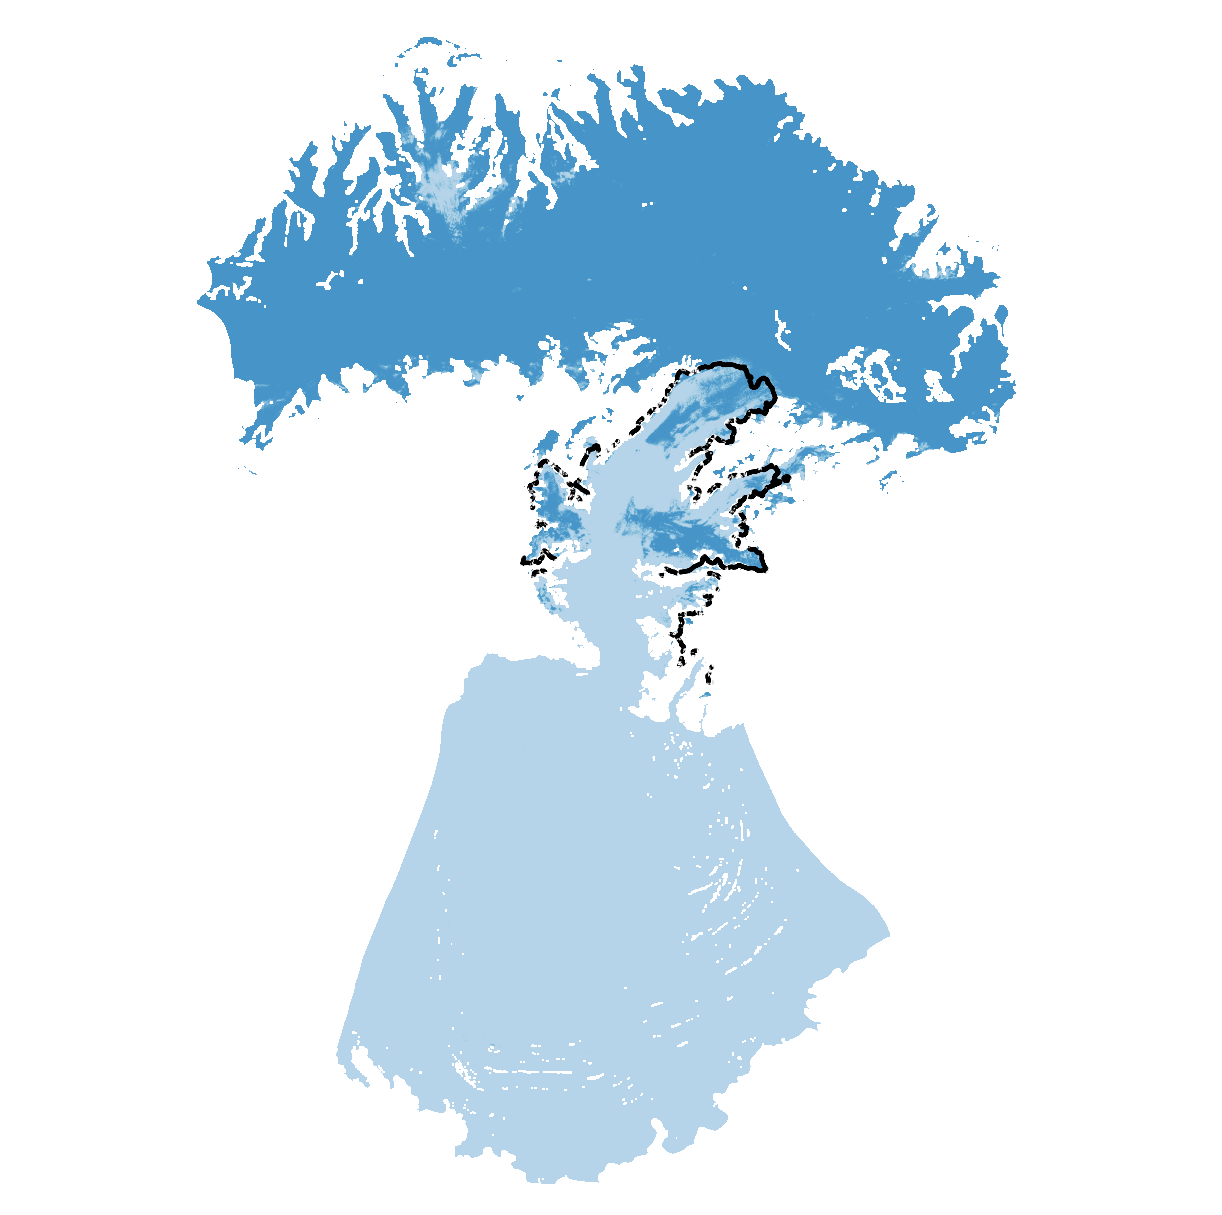

In [11]:
dem = xr_dem.astype(float)
dem = dem.where(dem>0, np.nan)

snow_plot = snow.astype(float)
snow_plot = snow_plot.where(snow_plot>0, np.nan)

fig,axs=plt.subplots(figsize=(5,5), dpi=300)
axs.axis('equal')
# dem.plot(ax=axs, cmap='terrain')

axs.imshow(snow.values[0], cmap='Blues', vmin=-1, vmax=2.3, zorder=1)
axs.contour(dem.values[0], levels=[1460], zorder=3, colors='black', linewidths=1)
# snow.plot(ax=axs, zorder=10, cmap='Blues', vmin=-1, vmax=1, add_colorbar=False)

axs.axis('off')
axs.set_title("")
# plt.savefig('wolverineela.png', transparent=True)

In [18]:
xr_dem

<xarray.DataArray (time: 1, y: 688, x: 519)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])
Coordinates:
  * x            (x) int32 276685 276695 276705 276715 ... 281845 281855 281865
  * y            (y) int32 1171505 1171495 1171485 ... 1164655 1164645 1164635
  * time         (time) datetime64[ns] 2020-01-01
    spatial_ref  int32 0

### Second step: go through those snow cover fraction products to calculate the ELA

In [4]:
all_obs = []
for i in range(len(rgis_to_analyze)):
#     if i>0: continue
    # subset rgi to single outline, by choosing rgiid or rgi name
    rgiid = rgis_to_analyze[i]
#     if rgiid!="RGI60-01.09162": continue
        
    # quickly grab glacier area
    ga = rgi_gdf[rgi_gdf['RGIId']==rgiid]['Area'].values[0]
#     if ga<3300: continue
    
    # define scale
    if ga>1000:
        scale=1
    elif ga>500:
        scale=1
    else:
        scale=1

    # print progress
    print(f"Starting {i+1} of {len(rgis_to_analyze)}: {rgiid}  {ga} km2")
    
    # open the csv hold elevation-band scfs
    open_path = os.path.join(folder_save, 'Average AAs', 'Band SCFs', f"{rgiid}.csv")
    scf_df = pd.read_csv(open_path)
    
    # calculate fraction of each band that was observed and that was snow (relative to observed)
    scf_df['observed_frac'] = scf_df['observed']/scf_df['total_pixels_possible'].fillna(0)
    scf_df['total_snow_frac'] = scf_df['snow']/scf_df['total_pixels_possible'].fillna(0)
    scf_df['snow_frac'] = scf_df['snow']/scf_df['observed'].fillna(0)
    
    ## we need to remove elevation bands that have essentially no observations.
    good_bands = (scf_df['observed']>50)
    df_to_use = scf_df[good_bands].reset_index()
    
    # transition to numpy array for a bit. snow fractions >=0.5 become 1 (accumulation zone)
    # everything <0.5 becomes 0 (ablation)
    np_accumulation = df_to_use['snow_frac'].values
    np_accumulation[np_accumulation>=0.5] = 1
    np_accumulation[np_accumulation<0.5] = 0
    
    # Define a kernel that sums the next 5 (4,3,2,1...) values along the 2nd dimension
    kernel5 = np.array([1, 1, 1, 1, 1, 0, 0, 0, 0])
    kernel4 = np.array([1, 1, 1, 1, 0, 0, 0])
    kernel3 = np.array([1, 1, 1, 0, 0])
    
    # apply kernel 5, see if we have an elevation band that is start of 5 accumulation bands in a row
    all_elas_5 = np.convolve(np_accumulation, kernel5, mode='same')==5
    all_elas_4 = np.convolve(np_accumulation, kernel4, mode='same')==4
    all_elas_3 = np.convolve(np_accumulation, kernel3, mode='same')==3
    
    first_ela_5 = np.argmax(all_elas_5, axis=0).astype(float)
    first_ela_4 = np.argmax(all_elas_4, axis=0).astype(float)
    first_ela_3 = np.argmax(all_elas_3, axis=0).astype(float)
    
    # if all 0s, replace with nan
    if all_elas_5.sum()==0: first_ela_5 = np.nan
    if all_elas_4.sum()==0: first_ela_4 = np.nan
    if all_elas_3.sum()==0: first_ela_3 = np.nan

    # get the final ela, by first taking from 5, then 4, then 3
    final_ela = first_ela_5
    if np.isnan(final_ela): final_ela = first_ela_4
    if np.isnan(final_ela): final_ela = first_ela_3
        
    # lastly, if we still have no ela (the entire glacier is ablation) we'll put the highest elevation band as the ela
    # make a separate flag for these
    off_glacier_flag = int(np.isnan(final_ela))
    
    # translate final_ela to elevation
    if np.isnan(final_ela):
        final_ela = df_to_use['z_min'].values[-1]
    else:
        final_ela = df_to_use['z_min'][final_ela]
    
    # calculate fraction observed, aar
    final_observed_frac = round(np.nansum(scf_df['observed'])/np.nansum(scf_df['total_pixels_possible']),4)
    final_aar = round(np.nansum(scf_df['snow'])/np.nansum(scf_df['observed']),4)
    total_area = np.nansum(scf_df['total_pixels_possible'])*scale*scale*10*10 / (1000*1000) #km2
    total_observed = np.nansum(scf_df['observed'])*scale*scale*10*10 / (1000*1000) #km2
    total_snow = np.nansum(scf_df['snow'])*scale*scale*10*10 / (1000*1000) #km2
    
    # format all the data for this glacier to save
    final_obs = {"RGIId":rgiid,
                 "ela":int(final_ela),
                 "aar":final_aar,
                 "off_glacier":off_glacier_flag,
                 "total_area":round(total_area,4),
                 "total_observed":round(total_observed,4),
                 "total_snow":round(total_snow,4)}
    
    # save to list
    all_obs.append(final_obs)

# format final df
all_obs_df = pd.DataFrame(all_obs)

# save
out_path = os.path.join(folder_save, 'Average AAs', 'final_glacier_stats.csv')
all_obs_df.to_csv(out_path, index=False)

print('Done!')

Starting 1 of 3002: RGI60-01.20889  2.0 km2
Starting 2 of 3002: RGI60-01.11632  2.0 km2
Starting 3 of 3002: RGI60-01.25183  2.002 km2
Starting 4 of 3002: RGI60-01.08203  2.002 km2
Starting 5 of 3002: RGI60-01.11595  2.003 km2
Starting 6 of 3002: RGI60-01.03614  2.004 km2
Starting 7 of 3002: RGI60-01.09047  2.004 km2
Starting 8 of 3002: RGI60-01.05487  2.004 km2
Starting 9 of 3002: RGI60-01.03088  2.005 km2
Starting 10 of 3002: RGI60-01.17509  2.005 km2
Starting 11 of 3002: RGI60-01.10867  2.005 km2
Starting 12 of 3002: RGI60-01.02453  2.006 km2
Starting 13 of 3002: RGI60-01.08199  2.006 km2
Starting 14 of 3002: RGI60-01.12977  2.006 km2
Starting 15 of 3002: RGI60-01.19457  2.007 km2
Starting 16 of 3002: RGI60-01.05254  2.009 km2
Starting 17 of 3002: RGI60-01.02906  2.01 km2
Starting 18 of 3002: RGI60-01.19826  2.012 km2
Starting 19 of 3002: RGI60-01.00315  2.014 km2
Starting 20 of 3002: RGI60-01.00564  2.015 km2
Starting 21 of 3002: RGI60-01.08366  2.016 km2
Starting 22 of 3002: RGI60-

Starting 175 of 3002: RGI60-01.02945  2.13 km2
Starting 176 of 3002: RGI60-01.00077  2.13 km2
Starting 177 of 3002: RGI60-01.13830  2.13 km2
Starting 178 of 3002: RGI60-01.00559  2.13 km2
Starting 179 of 3002: RGI60-01.03179  2.132 km2
Starting 180 of 3002: RGI60-01.10856  2.133 km2
Starting 181 of 3002: RGI60-01.20866  2.133 km2
Starting 182 of 3002: RGI60-01.00670  2.134 km2
Starting 183 of 3002: RGI60-01.05455  2.135 km2
Starting 184 of 3002: RGI60-01.09107  2.137 km2
Starting 185 of 3002: RGI60-01.01671  2.138 km2
Starting 186 of 3002: RGI60-01.01786  2.138 km2
Starting 187 of 3002: RGI60-01.06230  2.138 km2
Starting 188 of 3002: RGI60-01.22792  2.139 km2
Starting 189 of 3002: RGI60-01.23682  2.139 km2
Starting 190 of 3002: RGI60-01.24747  2.139 km2
Starting 191 of 3002: RGI60-01.23254  2.14 km2
Starting 192 of 3002: RGI60-01.07055  2.14 km2
Starting 193 of 3002: RGI60-01.04994  2.141 km2
Starting 194 of 3002: RGI60-01.23669  2.142 km2
Starting 195 of 3002: RGI60-01.18960  2.143 km

Starting 348 of 3002: RGI60-01.21276  2.275 km2
Starting 349 of 3002: RGI60-01.20198  2.275 km2
Starting 350 of 3002: RGI60-01.01278  2.275 km2
Starting 351 of 3002: RGI60-01.07046  2.276 km2
Starting 352 of 3002: RGI60-01.15491  2.277 km2
Starting 353 of 3002: RGI60-01.19385  2.278 km2
Starting 354 of 3002: RGI60-01.20508  2.278 km2
Starting 355 of 3002: RGI60-01.03688  2.278 km2
Starting 356 of 3002: RGI60-01.04161  2.278 km2
Starting 357 of 3002: RGI60-01.15254  2.279 km2
Starting 358 of 3002: RGI60-01.05049  2.279 km2
Starting 359 of 3002: RGI60-01.13917  2.28 km2
Starting 360 of 3002: RGI60-01.16834  2.281 km2
Starting 361 of 3002: RGI60-01.16288  2.281 km2
Starting 362 of 3002: RGI60-01.08681  2.282 km2
Starting 363 of 3002: RGI60-01.01721  2.284 km2
Starting 364 of 3002: RGI60-01.08080  2.284 km2
Starting 365 of 3002: RGI60-01.01331  2.285 km2
Starting 366 of 3002: RGI60-01.19568  2.286 km2
Starting 367 of 3002: RGI60-01.20974  2.286 km2
Starting 368 of 3002: RGI60-01.08472  2.2

Starting 534 of 3002: RGI60-01.05250  2.451 km2
Starting 535 of 3002: RGI60-01.03385  2.453 km2
Starting 536 of 3002: RGI60-01.19655  2.454 km2
Starting 537 of 3002: RGI60-01.08643  2.455 km2
Starting 538 of 3002: RGI60-01.26463  2.455 km2
Starting 539 of 3002: RGI60-01.03194  2.46 km2
Starting 540 of 3002: RGI60-01.08425  2.46 km2
Starting 541 of 3002: RGI60-01.10560  2.462 km2
Starting 542 of 3002: RGI60-01.05342  2.467 km2
Starting 543 of 3002: RGI60-01.01292  2.469 km2
Starting 544 of 3002: RGI60-01.12410  2.469 km2
Starting 545 of 3002: RGI60-01.17884  2.469 km2
Starting 546 of 3002: RGI60-01.18634  2.47 km2
Starting 547 of 3002: RGI60-01.22981  2.47 km2
Starting 548 of 3002: RGI60-01.05706  2.477 km2
Starting 549 of 3002: RGI60-01.18562  2.478 km2
Starting 550 of 3002: RGI60-01.18107  2.479 km2
Starting 551 of 3002: RGI60-01.16733  2.482 km2
Starting 552 of 3002: RGI60-01.26663  2.483 km2
Starting 553 of 3002: RGI60-01.23196  2.483 km2
Starting 554 of 3002: RGI60-01.12348  2.484 

Starting 716 of 3002: RGI60-01.18589  2.664 km2
Starting 717 of 3002: RGI60-01.19886  2.666 km2
Starting 718 of 3002: RGI60-01.10214  2.666 km2
Starting 719 of 3002: RGI60-01.08318  2.666 km2
Starting 720 of 3002: RGI60-01.09684  2.667 km2
Starting 721 of 3002: RGI60-01.22217  2.667 km2
Starting 722 of 3002: RGI60-01.10340  2.672 km2
Starting 723 of 3002: RGI60-01.19584  2.673 km2
Starting 724 of 3002: RGI60-01.07379  2.677 km2
Starting 725 of 3002: RGI60-01.00960  2.677 km2
Starting 726 of 3002: RGI60-01.00739  2.681 km2
Starting 727 of 3002: RGI60-01.16719  2.681 km2
Starting 728 of 3002: RGI60-01.14634  2.681 km2
Starting 729 of 3002: RGI60-01.20726  2.682 km2
Starting 730 of 3002: RGI60-01.08081  2.684 km2
Starting 731 of 3002: RGI60-01.04684  2.686 km2
Starting 732 of 3002: RGI60-01.03744  2.686 km2
Starting 733 of 3002: RGI60-01.05311  2.687 km2
Starting 734 of 3002: RGI60-01.22206  2.687 km2
Starting 735 of 3002: RGI60-01.15787  2.689 km2
Starting 736 of 3002: RGI60-01.17268  2.

Starting 888 of 3002: RGI60-01.09058  2.89 km2
Starting 889 of 3002: RGI60-01.20165  2.897 km2
Starting 890 of 3002: RGI60-01.08422  2.899 km2
Starting 891 of 3002: RGI60-01.05733  2.902 km2
Starting 892 of 3002: RGI60-01.22499  2.903 km2
Starting 893 of 3002: RGI60-01.12652  2.903 km2
Starting 894 of 3002: RGI60-01.21763  2.903 km2
Starting 895 of 3002: RGI60-01.15736  2.904 km2
Starting 896 of 3002: RGI60-01.10157  2.904 km2
Starting 897 of 3002: RGI60-01.00871  2.905 km2
Starting 898 of 3002: RGI60-01.05830  2.906 km2
Starting 899 of 3002: RGI60-01.08677  2.907 km2
Starting 900 of 3002: RGI60-01.15065  2.908 km2
Starting 901 of 3002: RGI60-01.26572  2.909 km2
Starting 902 of 3002: RGI60-01.19276  2.91 km2
Starting 903 of 3002: RGI60-01.23099  2.911 km2
Starting 904 of 3002: RGI60-01.20816  2.913 km2
Starting 905 of 3002: RGI60-01.06766  2.914 km2
Starting 906 of 3002: RGI60-01.11869  2.916 km2
Starting 907 of 3002: RGI60-01.22801  2.917 km2
Starting 908 of 3002: RGI60-01.16313  2.91

Starting 1069 of 3002: RGI60-01.17007  3.206 km2
Starting 1070 of 3002: RGI60-01.23021  3.207 km2
Starting 1071 of 3002: RGI60-01.00705  3.208 km2
Starting 1072 of 3002: RGI60-01.20999  3.213 km2
Starting 1073 of 3002: RGI60-01.11214  3.214 km2
Starting 1074 of 3002: RGI60-01.25137  3.214 km2
Starting 1075 of 3002: RGI60-01.13483  3.216 km2
Starting 1076 of 3002: RGI60-01.03667  3.22 km2
Starting 1077 of 3002: RGI60-01.14582  3.222 km2
Starting 1078 of 3002: RGI60-01.19065  3.224 km2
Starting 1079 of 3002: RGI60-01.03216  3.227 km2
Starting 1080 of 3002: RGI60-01.09954  3.229 km2
Starting 1081 of 3002: RGI60-01.23026  3.232 km2
Starting 1082 of 3002: RGI60-01.13431  3.234 km2
Starting 1083 of 3002: RGI60-01.17863  3.239 km2
Starting 1084 of 3002: RGI60-01.11315  3.239 km2
Starting 1085 of 3002: RGI60-01.03220  3.239 km2
Starting 1086 of 3002: RGI60-01.19048  3.243 km2
Starting 1087 of 3002: RGI60-01.08972  3.243 km2
Starting 1088 of 3002: RGI60-01.00377  3.244 km2
Starting 1089 of 3002

Starting 1242 of 3002: RGI60-01.21748  3.551 km2
Starting 1243 of 3002: RGI60-01.08159  3.554 km2
Starting 1244 of 3002: RGI60-01.02899  3.556 km2
Starting 1245 of 3002: RGI60-01.03748  3.559 km2
Starting 1246 of 3002: RGI60-01.05803  3.563 km2
Starting 1247 of 3002: RGI60-01.27110  3.564 km2
Starting 1248 of 3002: RGI60-01.24194  3.564 km2
Starting 1249 of 3002: RGI60-01.05528  3.564 km2
Starting 1250 of 3002: RGI60-01.05937  3.564 km2
Starting 1251 of 3002: RGI60-01.18872  3.565 km2
Starting 1252 of 3002: RGI60-01.22750  3.566 km2
Starting 1253 of 3002: RGI60-01.14599  3.567 km2
Starting 1254 of 3002: RGI60-01.10594  3.568 km2
Starting 1255 of 3002: RGI60-01.08269  3.573 km2
Starting 1256 of 3002: RGI60-01.00291  3.574 km2
Starting 1257 of 3002: RGI60-01.02784  3.578 km2
Starting 1258 of 3002: RGI60-01.03728  3.582 km2
Starting 1259 of 3002: RGI60-01.24845  3.584 km2
Starting 1260 of 3002: RGI60-01.07203  3.584 km2
Starting 1261 of 3002: RGI60-01.20902  3.585 km2
Starting 1262 of 300

Starting 1419 of 3002: RGI60-01.17355  3.957 km2
Starting 1420 of 3002: RGI60-01.15969  3.958 km2
Starting 1421 of 3002: RGI60-01.05300  3.964 km2
Starting 1422 of 3002: RGI60-01.12824  3.966 km2
Starting 1423 of 3002: RGI60-01.19338  3.971 km2
Starting 1424 of 3002: RGI60-01.10619  3.974 km2
Starting 1425 of 3002: RGI60-01.03895  3.975 km2
Starting 1426 of 3002: RGI60-01.07550  3.978 km2
Starting 1427 of 3002: RGI60-01.16871  3.979 km2
Starting 1428 of 3002: RGI60-01.21003  3.98 km2
Starting 1429 of 3002: RGI60-01.10531  3.981 km2
Starting 1430 of 3002: RGI60-01.10894  3.985 km2
Starting 1431 of 3002: RGI60-01.15162  3.994 km2
Starting 1432 of 3002: RGI60-01.19170  3.998 km2
Starting 1433 of 3002: RGI60-01.03215  3.998 km2
Starting 1434 of 3002: RGI60-01.22787  3.998 km2
Starting 1435 of 3002: RGI60-01.20629  4.0 km2
Starting 1436 of 3002: RGI60-01.19164  4.001 km2
Starting 1437 of 3002: RGI60-01.13414  4.004 km2
Starting 1438 of 3002: RGI60-01.17475  4.004 km2
Starting 1439 of 3002: 

Starting 1602 of 3002: RGI60-01.23032  4.534 km2
Starting 1603 of 3002: RGI60-01.10002  4.534 km2
Starting 1604 of 3002: RGI60-01.01810  4.534 km2
Starting 1605 of 3002: RGI60-01.01077  4.535 km2
Starting 1606 of 3002: RGI60-01.16411  4.536 km2
Starting 1607 of 3002: RGI60-01.16370  4.536 km2
Starting 1608 of 3002: RGI60-01.04866  4.536 km2
Starting 1609 of 3002: RGI60-01.22045  4.538 km2
Starting 1610 of 3002: RGI60-01.21007  4.54 km2
Starting 1611 of 3002: RGI60-01.22538  4.544 km2
Starting 1612 of 3002: RGI60-01.18047  4.545 km2
Starting 1613 of 3002: RGI60-01.26204  4.549 km2
Starting 1614 of 3002: RGI60-01.12166  4.55 km2
Starting 1615 of 3002: RGI60-01.09096  4.557 km2
Starting 1616 of 3002: RGI60-01.15499  4.557 km2
Starting 1617 of 3002: RGI60-01.08351  4.558 km2
Starting 1618 of 3002: RGI60-01.08197  4.56 km2
Starting 1619 of 3002: RGI60-01.20488  4.56 km2
Starting 1620 of 3002: RGI60-01.13807  4.565 km2
Starting 1621 of 3002: RGI60-01.05489  4.568 km2
Starting 1622 of 3002: R

Starting 1789 of 3002: RGI60-01.09647  5.33 km2
Starting 1790 of 3002: RGI60-01.19343  5.332 km2
Starting 1791 of 3002: RGI60-01.21762  5.338 km2
Starting 1792 of 3002: RGI60-01.02604  5.34 km2
Starting 1793 of 3002: RGI60-01.14562  5.344 km2
Starting 1794 of 3002: RGI60-01.08202  5.354 km2
Starting 1795 of 3002: RGI60-01.17893  5.361 km2
Starting 1796 of 3002: RGI60-01.20191  5.362 km2
Starting 1797 of 3002: RGI60-01.14420  5.363 km2
Starting 1798 of 3002: RGI60-01.21012  5.377 km2
Starting 1799 of 3002: RGI60-01.17305  5.378 km2
Starting 1800 of 3002: RGI60-01.21724  5.384 km2
Starting 1801 of 3002: RGI60-01.03151  5.388 km2
Starting 1802 of 3002: RGI60-01.17838  5.396 km2
Starting 1803 of 3002: RGI60-01.22479  5.399 km2
Starting 1804 of 3002: RGI60-01.03104  5.403 km2
Starting 1805 of 3002: RGI60-01.04463  5.411 km2
Starting 1806 of 3002: RGI60-01.13981  5.413 km2
Starting 1807 of 3002: RGI60-01.04330  5.416 km2
Starting 1808 of 3002: RGI60-01.05333  5.421 km2
Starting 1809 of 3002:

Starting 1963 of 3002: RGI60-01.02328  6.477 km2
Starting 1964 of 3002: RGI60-01.04457  6.478 km2
Starting 1965 of 3002: RGI60-01.19494  6.479 km2
Starting 1966 of 3002: RGI60-01.12308  6.491 km2
Starting 1967 of 3002: RGI60-01.23219  6.5 km2
Starting 1968 of 3002: RGI60-01.15684  6.5 km2
Starting 1969 of 3002: RGI60-01.23094  6.501 km2
Starting 1970 of 3002: RGI60-01.18051  6.525 km2
Starting 1971 of 3002: RGI60-01.22197  6.526 km2
Starting 1972 of 3002: RGI60-01.19713  6.528 km2
Starting 1973 of 3002: RGI60-01.12535  6.532 km2
Starting 1974 of 3002: RGI60-01.22010  6.539 km2
Starting 1975 of 3002: RGI60-01.05561  6.544 km2
Starting 1976 of 3002: RGI60-01.09538  6.554 km2
Starting 1977 of 3002: RGI60-01.02885  6.567 km2
Starting 1978 of 3002: RGI60-01.16481  6.567 km2
Starting 1979 of 3002: RGI60-01.19429  6.581 km2
Starting 1980 of 3002: RGI60-01.17919  6.594 km2
Starting 1981 of 3002: RGI60-01.15840  6.596 km2
Starting 1982 of 3002: RGI60-01.24677  6.605 km2
Starting 1983 of 3002: R

Starting 2142 of 3002: RGI60-01.19031  8.272 km2
Starting 2143 of 3002: RGI60-01.21758  8.284 km2
Starting 2144 of 3002: RGI60-01.14979  8.291 km2
Starting 2145 of 3002: RGI60-01.08284  8.309 km2
Starting 2146 of 3002: RGI60-01.20931  8.309 km2
Starting 2147 of 3002: RGI60-01.13659  8.327 km2
Starting 2148 of 3002: RGI60-01.05754  8.384 km2
Starting 2149 of 3002: RGI60-01.17195  8.386 km2
Starting 2150 of 3002: RGI60-01.18159  8.397 km2
Starting 2151 of 3002: RGI60-01.15544  8.398 km2
Starting 2152 of 3002: RGI60-01.18460  8.402 km2
Starting 2153 of 3002: RGI60-01.00574  8.432 km2
Starting 2154 of 3002: RGI60-01.15163  8.481 km2
Starting 2155 of 3002: RGI60-01.12242  8.482 km2
Starting 2156 of 3002: RGI60-01.17188  8.51 km2
Starting 2157 of 3002: RGI60-01.03871  8.543 km2
Starting 2158 of 3002: RGI60-01.01337  8.548 km2
Starting 2159 of 3002: RGI60-01.18143  8.592 km2
Starting 2160 of 3002: RGI60-01.03684  8.635 km2
Starting 2161 of 3002: RGI60-01.09492  8.638 km2
Starting 2162 of 3002

Starting 2316 of 3002: RGI60-01.08285  11.669 km2
Starting 2317 of 3002: RGI60-01.20300  11.715 km2
Starting 2318 of 3002: RGI60-01.13948  11.742 km2
Starting 2319 of 3002: RGI60-01.15766  11.767 km2
Starting 2320 of 3002: RGI60-01.20704  11.774 km2
Starting 2321 of 3002: RGI60-01.01151  11.78 km2
Starting 2322 of 3002: RGI60-01.10732  11.782 km2
Starting 2323 of 3002: RGI60-01.15238  11.788 km2
Starting 2324 of 3002: RGI60-01.00068  11.803 km2
Starting 2325 of 3002: RGI60-01.06696  11.827 km2
Starting 2326 of 3002: RGI60-01.03584  11.829 km2
Starting 2327 of 3002: RGI60-01.13457  11.833 km2
Starting 2328 of 3002: RGI60-01.20309  11.838 km2
Starting 2329 of 3002: RGI60-01.15189  11.858 km2
Starting 2330 of 3002: RGI60-01.01286  11.915 km2
Starting 2331 of 3002: RGI60-01.09862  11.933 km2
Starting 2332 of 3002: RGI60-01.09546  11.952 km2
Starting 2333 of 3002: RGI60-01.09664  11.962 km2
Starting 2334 of 3002: RGI60-01.01518  11.977 km2
Starting 2335 of 3002: RGI60-01.01803  11.985 km2
S

Starting 2488 of 3002: RGI60-01.08396  17.728 km2
Starting 2489 of 3002: RGI60-01.15378  17.799 km2
Starting 2490 of 3002: RGI60-01.05708  17.805 km2
Starting 2491 of 3002: RGI60-01.04439  17.84 km2
Starting 2492 of 3002: RGI60-01.16334  17.883 km2
Starting 2493 of 3002: RGI60-01.20981  17.901 km2
Starting 2494 of 3002: RGI60-01.19592  17.956 km2
Starting 2495 of 3002: RGI60-01.00557  18.042 km2
Starting 2496 of 3002: RGI60-01.17594  18.047 km2
Starting 2497 of 3002: RGI60-01.14879  18.073 km2
Starting 2498 of 3002: RGI60-01.23666  18.1 km2
Starting 2499 of 3002: RGI60-01.01525  18.123 km2
Starting 2500 of 3002: RGI60-01.04826  18.143 km2
Starting 2501 of 3002: RGI60-01.17920  18.199 km2
Starting 2502 of 3002: RGI60-01.04620  18.252 km2
Starting 2503 of 3002: RGI60-01.18045  18.272 km2
Starting 2504 of 3002: RGI60-01.10997  18.272 km2
Starting 2505 of 3002: RGI60-01.23563  18.299 km2
Starting 2506 of 3002: RGI60-01.20264  18.497 km2
Starting 2507 of 3002: RGI60-01.04954  18.52 km2
Star

Starting 2656 of 3002: RGI60-01.20751  31.139 km2
Starting 2657 of 3002: RGI60-01.12317  31.231 km2
Starting 2658 of 3002: RGI60-01.00572  31.256 km2
Starting 2659 of 3002: RGI60-01.15198  31.521 km2
Starting 2660 of 3002: RGI60-01.23660  31.586 km2
Starting 2661 of 3002: RGI60-01.17809  31.634 km2
Starting 2662 of 3002: RGI60-01.19515  31.701 km2
Starting 2663 of 3002: RGI60-01.16744  31.757 km2
Starting 2664 of 3002: RGI60-01.10621  32.03 km2
Starting 2665 of 3002: RGI60-01.03123  32.256 km2
Starting 2666 of 3002: RGI60-01.10290  32.257 km2
Starting 2667 of 3002: RGI60-01.23302  32.36 km2
Starting 2668 of 3002: RGI60-01.03490  32.748 km2
Starting 2669 of 3002: RGI60-01.20837  32.815 km2
Starting 2670 of 3002: RGI60-01.18048  32.833 km2
Starting 2671 of 3002: RGI60-01.12203  32.941 km2
Starting 2672 of 3002: RGI60-01.17434  32.945 km2
Starting 2673 of 3002: RGI60-01.00045  32.959 km2
Starting 2674 of 3002: RGI60-01.05647  32.96 km2
Starting 2675 of 3002: RGI60-01.02612  33.001 km2
Sta

Starting 2833 of 3002: RGI60-01.06618  82.89 km2
Starting 2834 of 3002: RGI60-01.00042  83.656 km2
Starting 2835 of 3002: RGI60-01.00556  83.953 km2
Starting 2836 of 3002: RGI60-01.15588  84.114 km2
Starting 2837 of 3002: RGI60-01.27103  86.656 km2
Starting 2838 of 3002: RGI60-01.04738  86.697 km2
Starting 2839 of 3002: RGI60-01.03825  88.976 km2
Starting 2840 of 3002: RGI60-01.11624  89.129 km2
Starting 2841 of 3002: RGI60-01.21015  89.492 km2
Starting 2842 of 3002: RGI60-01.23667  90.288 km2
Starting 2843 of 3002: RGI60-01.00041  90.905 km2
Starting 2844 of 3002: RGI60-01.00312  90.948 km2
Starting 2845 of 3002: RGI60-01.01514  91.099 km2
Starting 2846 of 3002: RGI60-01.09618  91.801 km2
Starting 2847 of 3002: RGI60-01.01854  92.229 km2
Starting 2848 of 3002: RGI60-01.19725  92.965 km2
Starting 2849 of 3002: RGI60-01.06279  93.071 km2
Starting 2850 of 3002: RGI60-01.12876  93.108 km2
Starting 2851 of 3002: RGI60-01.16757  93.23 km2
Starting 2852 of 3002: RGI60-01.10325  93.254 km2
St

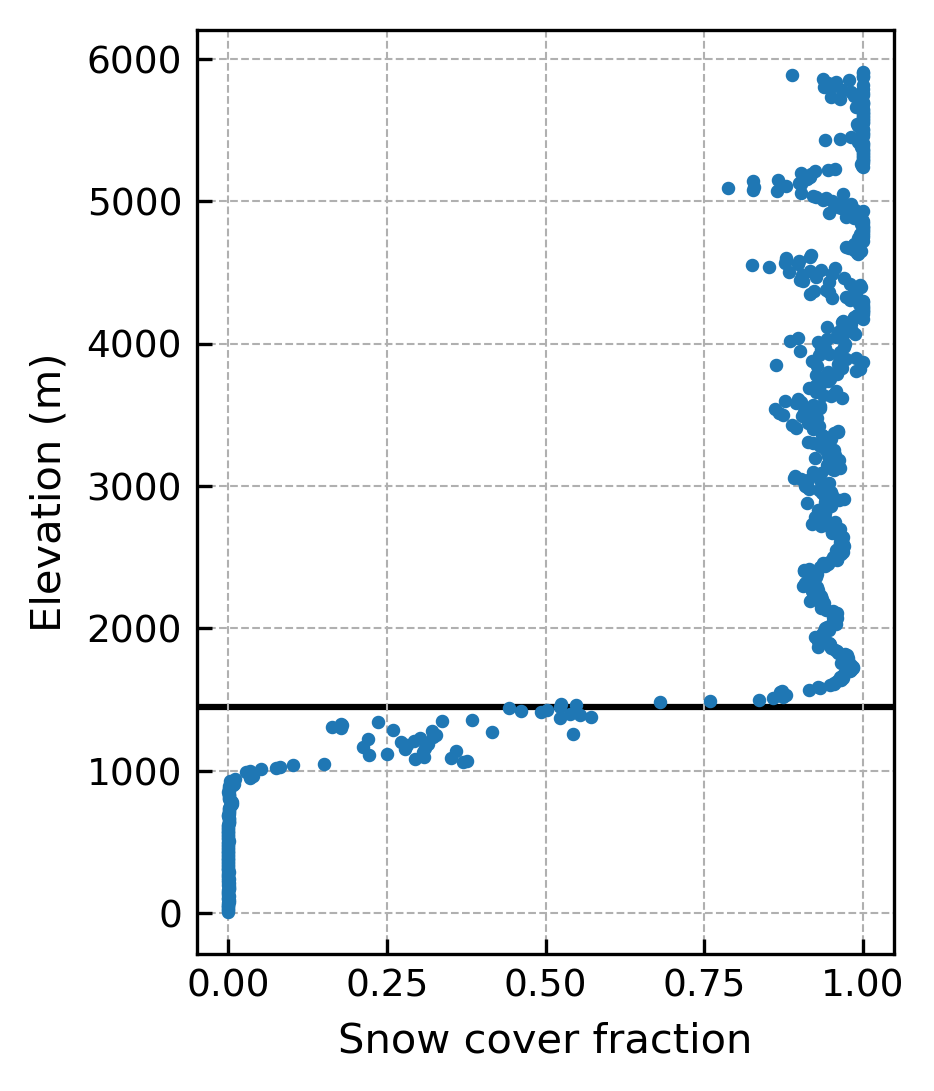

In [13]:
### make a quick figure to visualize the ELA process
fig,axs = plt.subplots(figsize=(3,4), dpi=300)
axs.scatter(scf_df["snow_frac"], scf_df["z_min"], c='tab:blue', s=5, zorder=3)

axs.hlines(final_ela, -0.1, 1.1, color='black', zorder=1)

# set tick and label stuff
axs.set_xlabel("Snow cover fraction", fontsize = 10)
axs.set_ylabel("Elevation (m)", fontsize = 10)
axs.set_xticks([0, 0.25, 0.5, 0.75, 1])
axs.tick_params(axis='both', direction='in', labelsize=9)

axs.set_xlim(-0.05, 1.05)

# add grid
axs.grid(zorder=1, linestyle='dashed', linewidth=0.5)

# scf_df

In [10]:
final_ela

1340.0